<a href="https://colab.research.google.com/github/lfa-systems/projeto-churn-ds/blob/main/Hackathon_ONE_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
# Importe as bibliotecas essenciais para manipulação de dados
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
# Carregamento do Dataset encontrado no link de download RAW (bruto).
url = 'https://raw.githubusercontent.com/lfa-systems/projeto-churn-ds/refs/heads/main/Dados/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv( url,  sep=',' )

# 🎓 Exploração e limpeza dos dados (EDA);

In [122]:
# Verificação
print("Dataset carregado com sucesso!")
print(df.head())

Dataset carregado com sucesso!
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Strea

In [123]:
# Execução do comando de verificação inicial
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [124]:
# 1. Antes da conversão, verificamos o tipo e a contagem de nulos (não detectados)
print("Tipo antes da conversão:", df['TotalCharges'].dtype)
print("Nulos (NaN) detectados inicialmente:", df['TotalCharges'].isnull().sum())

# Comando CRÍTICO: Conversão, transformando erros em NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Após a conversão, verificamos a contagem de nulos REAL
print("\nTipo após a conversão:", df['TotalCharges'].dtype)
nulos_identificados = df['TotalCharges'].isnull().sum()
print(f"Nulos (NaN) finalmente identificados: {nulos_identificados} (11 linhas)")

Tipo antes da conversão: object
Nulos (NaN) detectados inicialmente: 0

Tipo após a conversão: float64
Nulos (NaN) finalmente identificados: 11 (11 linhas)


In [125]:
# Contagem de linhas antes da remoção
linhas_antes = len(df)

# Comando para remover linhas onde TotalCharges é NaN
df.dropna(subset=['TotalCharges'], inplace=True)

# Contagem de linhas após a remoção
linhas_depois = len(df)

print(f"\nLinhas removidas: {linhas_antes - linhas_depois}")
print(f"Novo tamanho do DataFrame: {linhas_depois} entradas.")


Linhas removidas: 11
Novo tamanho do DataFrame: 7032 entradas.


In [126]:
# Mapeamento do texto para binário
if df['Churn'].dtype == 'object':
    print("Convertendo coluna 'Churn' de texto para binário...")

    # O np.where verifica a condição: Se df['Churn'] for igual a 'Yes' atrinui 1 senão atribui 0
    # E altera o tipo para int ormato que o Machine Learning espera.
    df['Churn'] = np.where(df['Churn'] == 'Yes', 1, 0).astype(int)

    print("Conversão concluída. Tipo atual:", df['Churn'].dtype)
else:
    print("Coluna 'Churn' já é numérica. Nenhuma ação necessária.")

Convertendo coluna 'Churn' de texto para binário...
Conversão concluída. Tipo atual: int64


1. ### 🧹 Refinamento da Limpeza: Remover Colunas Irrelevantes  
A coluna `customerID` é um identificador único. Ela não ajuda o modelo a aprender padrões (na verdade, pode até confundir), então devemos removê-la logo no início da análise.

In [127]:
# Remover customerID pois não agrega valor preditivo
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print("Coluna 'customerID' removida com sucesso.")

Coluna 'customerID' removida com sucesso.


2. ### 📈 EDA Estatística: O "Raio-X" dos Números
O uso do describe() para entender a escala das suas variáveis numéricas (tenure, MonthlyCharges, TotalCharges). Isso ajudará a decidir como aplicar o StandardScaler depois.

In [128]:
# Estatísticas descritivas para colunas numéricas
display(df.describe())

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


O que observar aqui:

Outliers: O valor máximo está muito longe da média?

Escala: Note que tenure vai de 1 a 72, enquanto TotalCharges vai até ~8600. Isso confirma a necessidade de normalização (scaling).

3. ### 🔍 Consistência de Categorias
No dataset, muitas colunas têm três valores: "Yes", "No" e "No internet service".  
Na prática, "No internet service" muitas vezes significa apenas "No".

In [129]:
# Verificar valores únicos em colunas categóricas para identificar redundâncias
def verificar_redundancias(df):
    for col in df.select_dtypes(include='object').columns:
        print(f"{col}: {df[col].unique()}")

verificar_redundancias(df)


gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [130]:
# 1. Lista das colunas que possuem a categoria "No internet service"
colunas_internet = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# 2. Percorrer a lista e substituir "No internet service" por "No"
for col in colunas_internet:
    # O método replace troca o valor específico em toda a coluna
    df[col] = df[col].replace('No internet service', 'No')

# 3. Tratar também a coluna 'MultipleLines', que possui "No phone service"
# Seguimos a mesma lógica: se não tem serviço de telefone, o valor para linhas múltiplas é "No"
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

# --- Verificação dos Resultados ---

print("Verificação das categorias após a limpeza:")

verificar_redundancias(df)

Verificação das categorias após a limpeza:
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### 🩸 Teste de Sanidade ou Matriz de Confusão de cruzamento  
Questionameto se a regra de negócio do dataset é respeitada nos registros:  
Se `PhoneService` é "No", `MultipleLines` precisa ser "No phone service"?  
Se `InternetService` é "No", os serviços adicionais precisam ser "No internet service"?

In [131]:
# Cruzamento entre Serviço de Telefone e Linhas Múltiplas
print("Verificação: PhoneService vs MultipleLines")
print(pd.crosstab(df['PhoneService'], df['MultipleLines']))

Verificação: PhoneService vs MultipleLines
MultipleLines    No   Yes
PhoneService             
No              680     0
Yes            3385  2967


In [132]:
# Lista de colunas dependentes da internet
servicos_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

print("\nVerificação: InternetService vs Serviços Adicionais")
for col in servicos_internet:
    print(f"\n--- {col} ---")
    print(pd.crosstab(df['InternetService'], df[col]))


Verificação: InternetService vs Serviços Adicionais

--- OnlineSecurity ---
OnlineSecurity     No   Yes
InternetService            
DSL              1240  1176
Fiber optic      2257   839
No               1520     0

--- OnlineBackup ---
OnlineBackup       No   Yes
InternetService            
DSL              1334  1082
Fiber optic      1753  1343
No               1520     0

--- DeviceProtection ---
DeviceProtection    No   Yes
InternetService             
DSL               1355  1061
Fiber optic       1739  1357
No                1520     0

--- TechSupport ---
TechSupport        No   Yes
InternetService            
DSL              1242  1174
Fiber optic      2230   866
No               1520     0

--- StreamingTV ---
StreamingTV        No   Yes
InternetService            
DSL              1463   953
Fiber optic      1346  1750
No               1520     0

--- StreamingMovies ---
StreamingMovies    No   Yes
InternetService            
DSL              1436   980
Fiber optic      13

In [133]:
verificar_redundancias(df)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [134]:
# Lista de colunas com apenas duas opções (Binárias)
colunas_binarias = [
    'gender', 'Partner', 'Dependents', 'PhoneService',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'PaperlessBilling', 'Churn'
]

# Aplicar o LabelEncoder (Transforma em 0 e 1)
le = LabelEncoder()
for col in colunas_binarias:
    # O fit_transform aprende quem é 0 e quem é 1 e já aplica
    df[col] = le.fit_transform(df[col])

In [135]:
# Colunas com mais de 2 opções (One-Hot Encoding)
# Isso criará colunas separadas para Contract, PaymentMethod e InternetService
df_final = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'])

In [136]:
df_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,1,0,0,0,34,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,1,0,0,0,2,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,1,0,0,0,45,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,0,0,0,0,2,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


In [137]:
print("--- VALORES ÚNICOS POR COLUNA ---")
for col in df_final.columns:
    # Mostra o nome da coluna e os valores (0, 1, etc)
    valores = df_final[col].unique()
    print(f"{col:25} : {valores}")

--- VALORES ÚNICOS POR COLUNA ---
gender                    : [0 1]
SeniorCitizen             : [0 1]
Partner                   : [1 0]
Dependents                : [0 1]
tenure                    : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService              : [0 1]
MultipleLines             : [0 1]
OnlineSecurity            : [0 1]
OnlineBackup              : [1 0]
DeviceProtection          : [0 1]
TechSupport               : [0 1]
StreamingTV               : [0 1]
StreamingMovies           : [0 1]
PaperlessBilling          : [1 0]
MonthlyCharges            : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges              : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn                     : [0 1]
InternetService_DSL       : [ True False]
InternetService_Fiber optic : [False  True]
Inte

# Mapa de Calor (Heatmap)
O mapa usa cores para indicar a força da relação entre duas variáveis: Vermelho forte indica correlação positiva (quando uma sobe, a outra sobe), Azul forte indica correlação negativa (quando uma sobe, a outra desce) e Cinzento/Branco indica que não há relação linear.

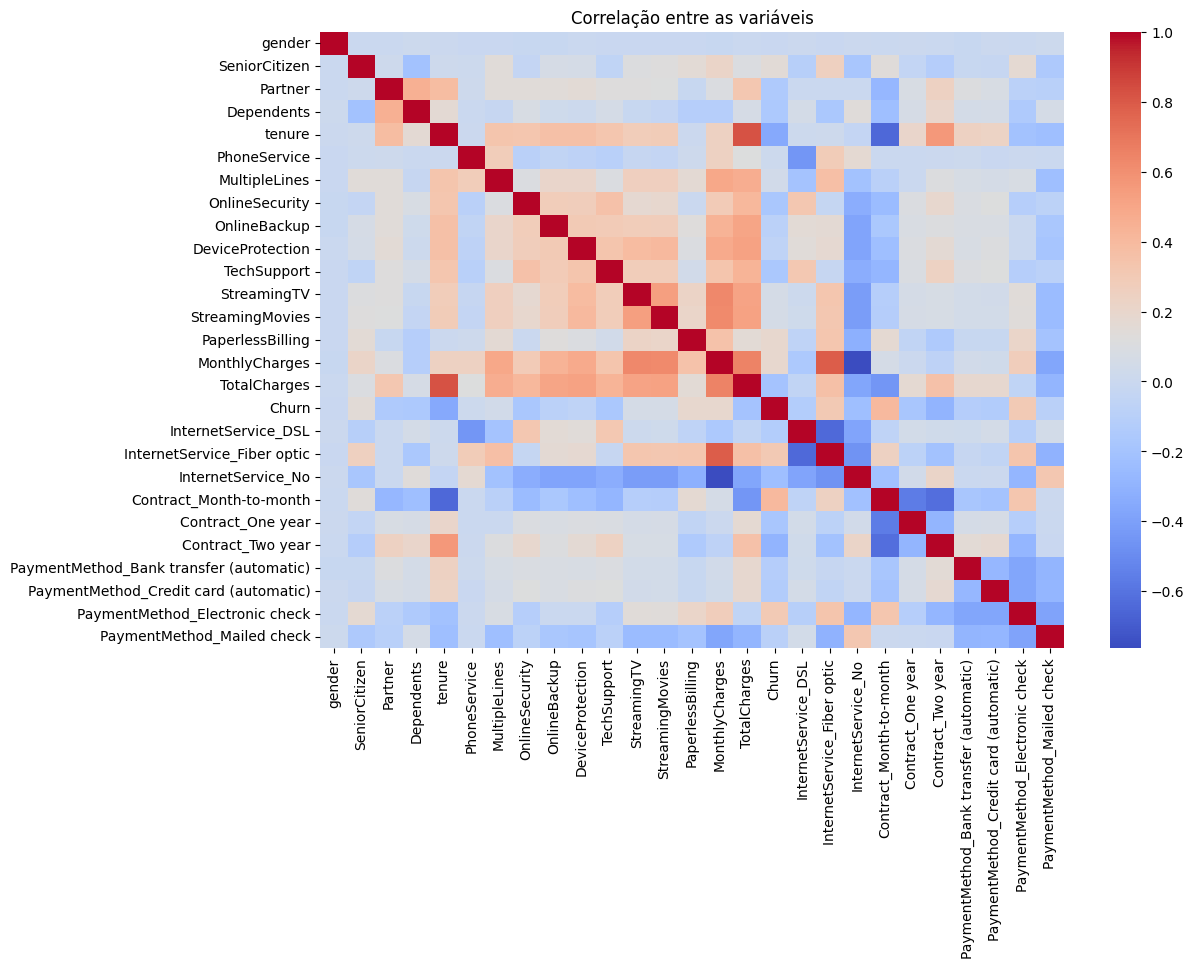

In [138]:
# Verificar Correlação (O Mapa de Calor)
# Saber se existem colunas que dizem a mesma coisa.
# Se duas colunas forem quase idênticas (ex: TotalCharges e tenure), elas podem confundir o modelo.
def correlacao():
  plt.figure(figsize=(12, 8))
  sns.heatmap(df_final.corr(), annot=False, cmap='coolwarm')
  plt.title("Correlação entre as variáveis")
  plt.show()

correlacao()

## Observe no gráfico acima o quadrado vermelho escuro no cruzamento entre `tenure` e `TotalCharges`, e também entre `MonthlyCharges` e `TotalCharges.
* O que significa: Existe uma correlação altíssima (perto de 0.8 ou mais). Isso é óbvio matematicamente: o Valor Total pago é basicamente o Tempo de Contrato multiplicado pela Mensalidade.

* Ação Recomendada: Ter variáveis que "dizem a mesma coisa" pode atrapalhar modelos lineares (Regressão Logística). Muitos cientistas de dados optam por remover TotalCharges e manter apenas tenure e MonthlyCharges para evitar redundância.

In [139]:
# Removendo a coluna redundante para evitar multicolinearidade
df_final = df_final.drop(columns=['TotalCharges'])

print("Coluna 'TotalCharges' removida com sucesso!")

Coluna 'TotalCharges' removida com sucesso!


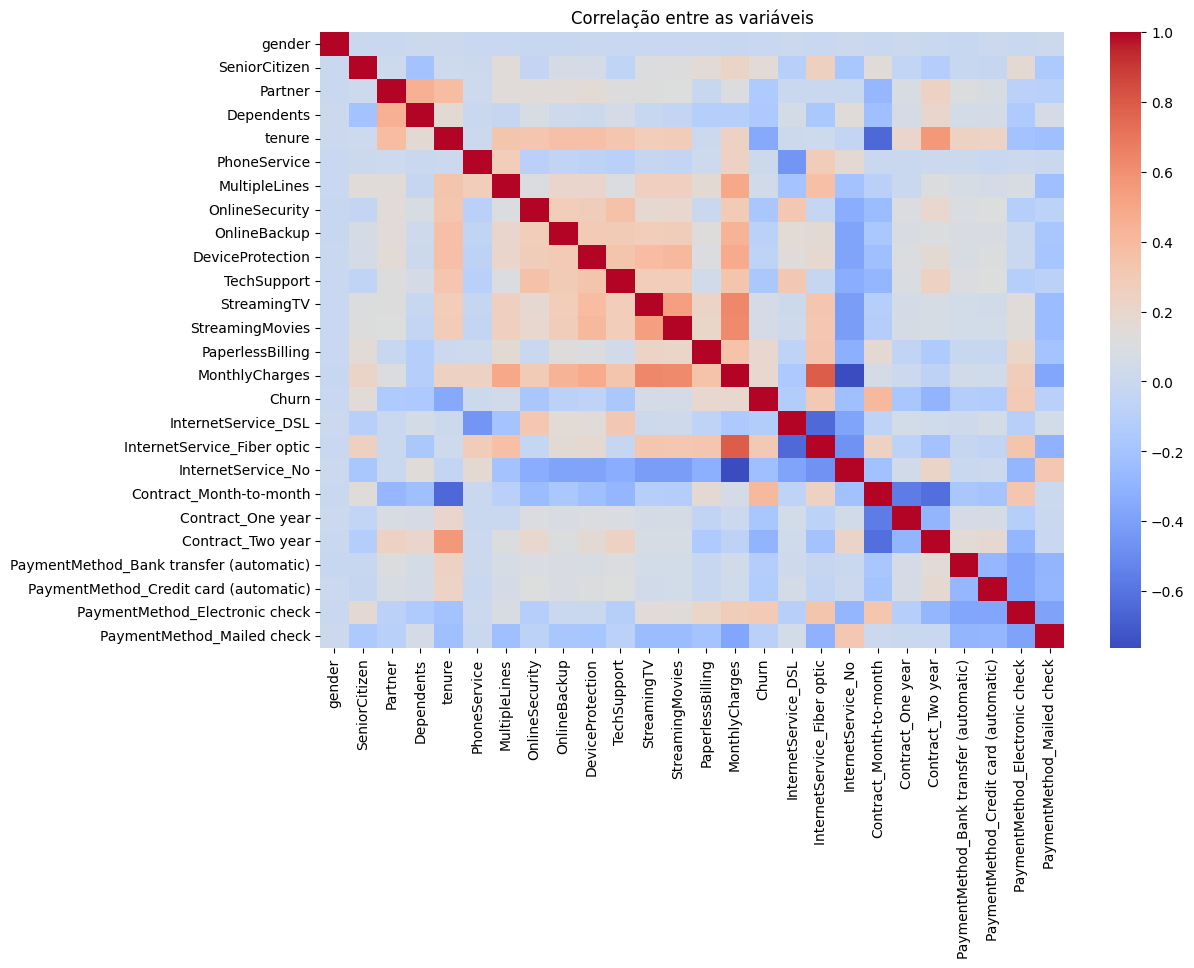

In [140]:
correlacao();

Diferente do vermelho forte (que indica redundância), o azul indica que quando uma variável sobe, a outra desce.

Exemplo no seu gráfico: A relação entre tenure (tempo) e Churn é azul.

Tradução: Quanto maior o tempo de casa do cliente, menor a chance de ele cancelar. Isso é um padrão real e o modelo precisa dessa "pista" para ser preciso.